In [12]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("drive/MyDrive/colabFiles/Google_Stock_Train.csv")
df = df[int(len(df) * .8):]


In [13]:
df.index = pd.to_datetime(df['Date'], format='%Y-%m-%d')
prices = df[['Close']]
prices

,Close
Date,
2020-05-28,70.912003
2020-05-29,71.676003
2020-06-01,71.743500
2020-06-02,72.115501
2020-06-03,71.962502
...,...
2022-12-23,89.230003
2022-12-27,87.389999
2022-12-28,86.019997


<Axes: xlabel='Date'>

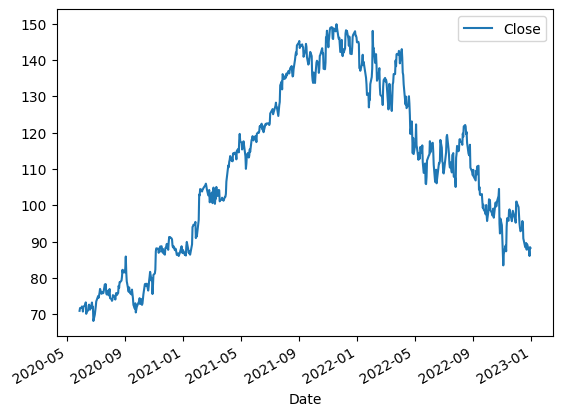

In [14]:
prices.plot()

In [15]:
def df_to_X_y(df, window_size=5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [a for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label[0])
  return np.array(X), np.array(y)

In [16]:
WINDOW_SIZE = 5
X, y = df_to_X_y(prices, WINDOW_SIZE)

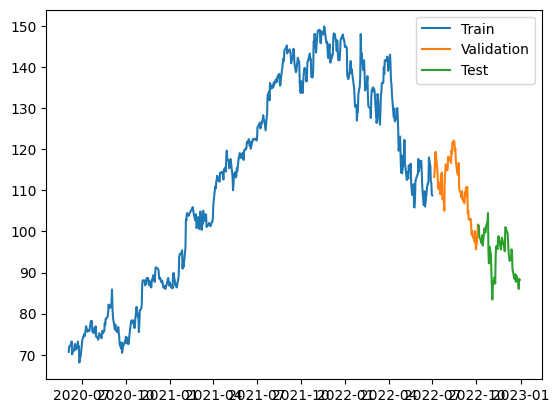

In [17]:
q_80 = int(len(prices) * .8)
q_90 = int(len(prices) * .9)
dates = prices.index[WINDOW_SIZE:]

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])


In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20)

Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 13042.6377 - mean_absolute_error: 111.2157 - val_loss: 11882.4766 - val_mean_absolute_error: 108.7762
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 12491.8330 - mean_absolute_error: 108.7316 - val_loss: 11029.8926 - val_mean_absolute_error: 104.7824
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 11738.6182 - mean_absolute_error: 105.3714 - val_loss: 9372.4834 - val_mean_absolute_error: 96.5497
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9734.6465 - mean_absolute_error: 95.2583 - val_loss: 6762.1562 - val_mean_absolute_error: 81.9003
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6484.7490 - mean_absolute_error: 75.5179 - val_loss: 2293.5562 - val_mean_absolute_error: 47.2804
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2395.8264 - mean_absolute_error: 41.3010 - val_loss: 119.4034 - val_mean_absolute_error: 9.4564
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - los

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


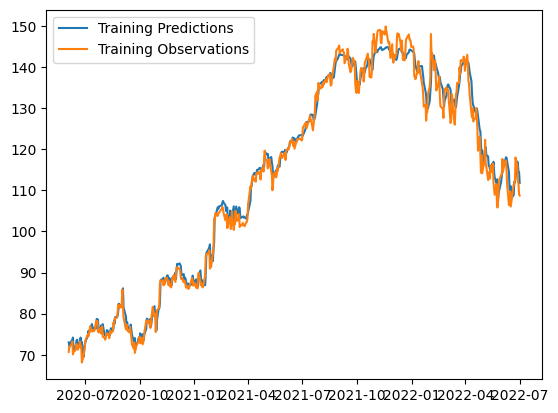

In [19]:
train_predictions = model.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train})
train_results
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


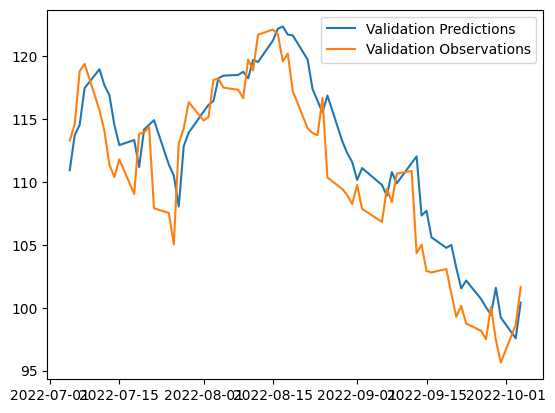

In [20]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


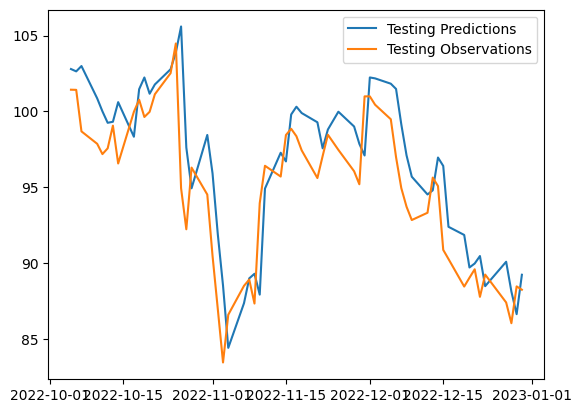

In [21]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [22]:
def calculate_mape(actual, predicted):
    """
    Calculate Mean Absolute Percentage Error (MAPE).

    """
    actual, predicted = np.array(actual), np.array(predicted)

    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    return mape




def calculate_directional_accuracy(actual, predicted):
    """
    Calculate Directional Accuracy (DA).

    Parameters:
    actual (np.array): Actual prices.
    predicted (np.array): Predicted prices.

    Returns:
    float: Directional accuracy as a percentage.
    """
    # Calculate actual and predicted direction changes
    actual_direction = np.sign(np.diff(actual))
    predicted_direction = np.sign(np.diff(predicted))
    # Calculate matches
    correct_directions = np.sum(actual_direction == predicted_direction)
    # Calculate directional accuracy
    return (correct_directions / len(actual_direction)) * 100





def simulate_trading_profit(actual, predicted):
    """
    Simulate trading profits based on predicted and actual prices.

    Parameters:
    actual (np.array): Actual prices.
    predicted (np.array): Predicted prices.

    Returns:
    float: Cumulative profit from the trading strategy.
    """
    # Define positions based on predicted direction (buy = +1, sell = -1)
    predicted_direction = np.sign(np.diff(predicted))
    # Calculate daily profits: (next day's price - current price) * position
    daily_profits = predicted_direction * np.diff(actual)
    # Calculate cumulative profit
    cumulative_profit = np.sum(daily_profits)
    return cumulative_profit, np.cumsum(daily_profits)

mape = calculate_mape(y_test, test_predictions)
directional_accuracy = calculate_directional_accuracy(y_test, test_predictions)
cumulative_profit, cumulative_profit_steps = simulate_trading_profit(y_test, test_predictions)

mape, directional_accuracy, cumulative_profit

(2.598822297166036, 55.00000000000001, -6.060013000000012)